In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import pandas as pd
import geopandas as gpd
import mscthesis
import plotly.express as px
import plotly as plt
import plotly.graph_objects as pgo
from plotly.offline import init_notebook_mode
import numpy as np

In [21]:
init_notebook_mode(connected=True)

In [32]:
import saopaulo

In [4]:
geotweets = mscthesis.tweets_from_sqlite("saopaulo/saopaulo.sqlite3")

In [5]:
geotweets

tweetid              userid                  createdat  \
0        593729000528293889                2542  2015-04-30 10:49:59+00:00   
1        593778202625110016                2542  2015-04-30 14:05:30+00:00   
2        593879849619558400                2542  2015-04-30 20:49:24+00:00   
3        593906922648113152                2542  2015-04-30 22:36:59+00:00   
4        594316669008359425                2542  2015-05-02 01:45:10+00:00   
...                     ...                 ...                        ...   
8059443  864441546241867777  808993056951271424  2017-05-16 11:24:59+00:00   
8059444  867520539149160448  808993056951271424  2017-05-24 23:19:48+00:00   
8059445  883876403942486016  808993056951271424  2017-07-09 02:32:10+00:00   
8059446  884085965823889408  808993056951271424  2017-07-09 16:24:54+00:00   
8059447  892015433254977536  808993056951271424  2017-07-31 13:33:46+00:00   

          latitude  longitude  month  weekday  hourofday           timezone  
0       -23.504890 -46.834459      4        4          7  America/Sao_Paulo  
1       -23.505736 -46.837917      4        4         11  America/Sao_Paulo  
2       -23.498245 -46.852135      4        4         17  America/Sao_Paulo  
3       -23.498235 -46.857403      4        4         19  America/Sao_Paulo  
4       -23.505362 -46.875272      5        5         22  America/Sao_Paulo  
...            ...        ...    ...      ...        ...                ...  
8059443 -23.584500 -46.627680      5        2          8  America/Sao_Paulo  
8059444 -23.633500 -46.736200      5        3         20  America/Sao_Paulo  
8059445 -23.584500 -46.627680      7        6         23  America/Sao_Paulo  
8059446 -23.590721 -46.635019      7        0         13  America/Sao_Paulo  
8059447 -23.583300 -46.633300      7        1         10  America/Sao_Paulo  

[8059448 rows x 9 columns]

In [6]:
geotweets['createdat'] = pd.to_datetime(geotweets['createdat'], infer_datetime_format=True)

In [7]:
geotweets = geotweets.set_index(['userid', 'createdat']).sort_index()

# Filter out users few tweets

We assume that no patterns will emerge for users with less than 50 tweets, due to sparsity.


count    22853.000000
mean       352.664770
std        500.497831
min          1.000000
25%         42.000000
50%        151.000000
75%        450.000000
max       3244.000000
dtype: float64

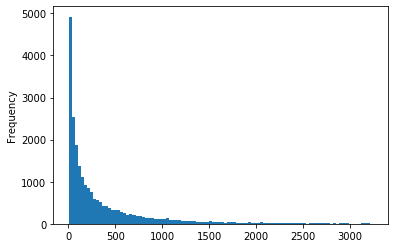

In [8]:
tweet_count_before = geotweets.groupby('userid').size()
tweet_count_before.plot.hist(bins=100)
tweet_count_before.describe()

In [9]:
geotweets = geotweets.drop(
    labels=tweet_count_before[tweet_count_before <= 50].index, 
    level=0,
)

count    16482.00000
mean       481.07669
std        536.74825
min         51.00000
25%        125.00000
50%        275.00000
75%        619.00000
max       3244.00000
dtype: float64

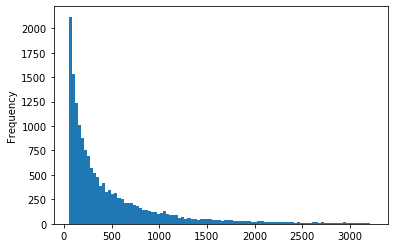

In [10]:
tweet_count = geotweets.groupby('userid').size()
tweet_count.plot.hist(bins=100)
tweet_count.describe()

In [11]:
geotweets = geotweets.reset_index('createdat')

In [12]:
geotweets = geotweets.assign(ym=geotweets['createdat'].dt.to_period('M'))

/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1099: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [13]:
_geotweets = geotweets.loc[geotweets.index.unique()[:100]]

# Home location

In [14]:
geotweetsx = mscthesis.cluster(geotweets)
_geotweetsx = mscthesis.cluster(_geotweets)

In [15]:
geotweetsx = mscthesis.label_home(geotweetsx)
_geotweetsx = mscthesis.label_home(_geotweetsx)

## Remove tweets not in home period

Considering the long period of tweets, it is likely that users have moved between homes. To simplify our model we only keep tweets that are during detected home's "period".


In [16]:
geotweetsx = mscthesis.remove_tweets_outside_home_period(geotweetsx)
_geotweetsx = mscthesis.remove_tweets_outside_home_period(_geotweetsx)

In [23]:
user_active_period_before = geotweets.groupby('userid').apply(lambda df: df.createdat.max() - df.createdat.min())
user_active_period_after = geotweetsx.groupby('userid').apply(lambda df: df.createdat.max() - df.createdat.min())
pgo.Figure(
    [
        pgo.Histogram(x=user_active_period_before.dt.days, name="Before"),
        pgo.Histogram(x=user_active_period_after.dt.days, name="After"),
    ],
    pgo.Layout(xaxis=dict(title='Days active')),
)

In [22]:
old = geotweets.groupby('ym').size()
new = geotweetsx.groupby('ym').size()
pgo.Figure([
    pgo.Bar(x=old.index.astype(str), y=old.values, name="Before"),
    pgo.Bar(x=new.index.astype(str), y=new.values, name="After")
])

## Remove users not in region

In [24]:
def get_homelocations(ts):
    _ts = ts.query('label == "home"').groupby(['userid', 'region']).head(1)
    return gpd.GeoDataFrame(
        _ts,
        crs='EPSG:4326',
        geometry=gpd.points_from_xy(_ts['longitude'], _ts['latitude'])
    )
        
homelocations = get_homelocations(geotweetsx)
_homelocations = get_homelocations(_geotweetsx)

In [25]:
fig = px.scatter_mapbox(
    homelocations.reset_index(), 
    lat='latitude', lon='longitude', 
    hover_data = ['userid']
)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

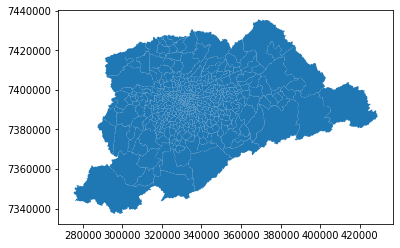

In [50]:
saopaulo.zones().plot()

In [33]:
boundary = saopaulo.boundary()

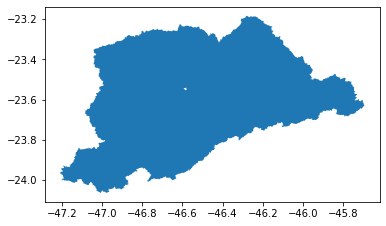

In [39]:
boundary.plot()

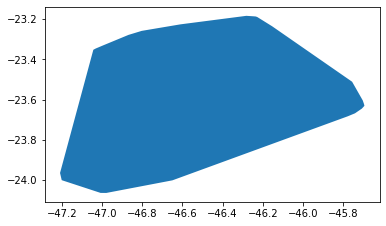

In [38]:
boundary.convex_hull.plot()

In [40]:
homelocationsx = gpd.clip(homelocations, boundary.convex_hull)
_homelocationsx = gpd.clip(_homelocations, boundary.convex_hull)

In [41]:
homelocationsx

region                 createdat              tweetid  \
userid                                                                      
2542                   235 2017-02-03 09:45:29+00:00   827452943972564993   
3363                    17 2018-11-06 20:38:42+00:00  1059907952436568065   
332923                  26 2011-05-12 21:21:08+00:00    68787820118020096   
550993                   2 2013-12-21 15:49:21+00:00   414422344753360897   
803348                  42 2019-03-06 16:49:57+00:00  1103336930652106752   
...                    ...                       ...                  ...   
801504395057889281       0 2016-11-23 19:45:27+00:00   801512001029763072   
802873516295127040       0 2016-11-28 15:28:08+00:00   803259185689309184   
803331889356505090       3 2016-12-05 08:20:59+00:00   805688405493481472   
803577565722148865       0 2016-12-10 08:12:23+00:00   807498182414438400   
803997550726549504       6 2016-12-08 13:30:26+00:00   806853446250991621   

                     latitude  longitude  month  weekday  hourofday  \
userid                                                                
2542               -23.562703 -46.697775      2        5          7   
3363               -23.557758 -46.635835     11        2         18   
332923             -23.589239 -46.655470      5        4         18   
550993             -23.557030 -46.665320     12        6         13   
803348             -23.526552 -46.681138      3        3         13   
...                       ...        ...    ...      ...        ...   
801504395057889281 -23.670971 -46.448904     11        3         17   
802873516295127040 -23.499348 -46.637654     11        1         13   
803331889356505090 -23.706765 -46.571274     12        1          6   
803577565722148865 -23.594616 -46.644911     12        6          6   
803997550726549504 -23.571815 -46.708524     12        4         11   

                             timezone       ym label  \
userid                                                 
2542                America/Sao_Paulo  2017-02  home   
3363                America/Sao_Paulo  2018-11  home   
332923              America/Sao_Paulo  2011-05  home   
550993              America/Sao_Paulo  2013-12  home   
803348              America/Sao_Paulo  2019-03  home   
...                               ...      ...   ...   
801504395057889281  America/Sao_Paulo  2016-11  home   
802873516295127040  America/Sao_Paulo  2016-11  home   
803331889356505090  America/Sao_Paulo  2016-12  home   
803577565722148865  America/Sao_Paulo  2016-12  home   
803997550726549504  America/Sao_Paulo  2016-12  home   

                                       geometry  
userid                                           
2542                POINT (-46.69777 -23.56270)  
3363                POINT (-46.63583 -23.55776)  
332923              POINT (-46.65547 -23.58924)  
550993              POINT (-46.66532 -23.55703)  
803348              POINT (-46.68114 -23.52655)  
...                                         ...  
801504395057889281  POINT (-46.44890 -23.67097)  
802873516295127040  POINT (-46.63765 -23.49935)  
803331889356505090  POINT (-46.57127 -23.70677)  
803577565722148865  POINT (-46.64491 -23.59462)  
803997550726549504  POINT (-46.70852 -23.57181)  

[11829 rows x 12 columns]

In [42]:
pgo.Figure(
    [
        pgo.Scattermapbox(lat=homelocations['latitude'], lon=homelocations['longitude'], fillcolor='red'),
        pgo.Scattermapbox(lat=homelocationsx['latitude'], lon=homelocationsx['longitude'], fillcolor='blue'),
    ],
    layout=pgo.Layout(
        
        mapbox=pgo.layout.Mapbox(style='open-street-map'))
)

In [43]:
geotweetsy = geotweetsx[geotweetsx.index.isin(homelocationsx.index)]
_geotweetsy = _geotweetsx[_geotweetsx.index.isin(_homelocationsx.index)]

In [44]:
geotweetsy

region                 createdat             tweetid  \
userid                                                                     
2542                     0 2017-10-20 17:16:04+00:00  921424793836105728   
2542                     0 2017-10-20 21:56:50+00:00  921495449693032448   
2542                     0 2017-10-23 12:53:42+00:00  922445929231343616   
2542                     0 2017-11-24 15:30:20+00:00  934081758068436992   
2542                     0 2017-11-24 15:30:32+00:00  934081809566130176   
...                    ...                       ...                 ...   
803997550726549504      37 2017-03-14 11:39:16+00:00  841614705802268672   
803997550726549504      38 2017-03-14 11:40:28+00:00  841615004214394881   
803997550726549504      38 2017-03-23 11:42:02+00:00  844876892322877440   
803997550726549504      39 2017-03-21 23:47:11+00:00  844334606350372864   
803997550726549504      40 2017-03-25 00:46:14+00:00  845436627275132928   

                     latitude  longitude  month  weekday  hourofday  \
userid                                                                
2542               -23.504909 -46.834345     10        5         15   
2542               -23.504831 -46.834689     10        5         19   
2542               -23.504909 -46.834345     10        1         10   
2542               -23.504759 -46.834335     11        5         13   
2542               -23.504909 -46.834345     11        5         13   
...                       ...        ...    ...      ...        ...   
803997550726549504 -23.551689 -46.757425      3        2          8   
803997550726549504 -23.547055 -46.761001      3        2          8   
803997550726549504 -23.547055 -46.761001      3        4          8   
803997550726549504 -23.655782 -46.718764      3        2         20   
803997550726549504 -23.619030 -46.748593      3        5         21   

                             timezone       ym  label  
userid                                                 
2542                America/Sao_Paulo  2017-10  other  
2542                America/Sao_Paulo  2017-10  other  
2542                America/Sao_Paulo  2017-10  other  
2542                America/Sao_Paulo  2017-11  other  
2542                America/Sao_Paulo  2017-11  other  
...                               ...      ...    ...  
803997550726549504  America/Sao_Paulo  2017-03  other  
803997550726549504  America/Sao_Paulo  2017-03  other  
803997550726549504  America/Sao_Paulo  2017-03  other  
803997550726549504  America/Sao_Paulo  2017-03  other  
803997550726549504  America/Sao_Paulo  2017-03  other  

[4006450 rows x 11 columns]

In [45]:
geotweetsy.to_csv('../../dbs/saopaulo/geotweets.csv')

In [47]:
homelocationsy = homelocationsx.to_crs('EPSG:3006').reset_index()
homelocationsy = pd.DataFrame.from_dict(dict(
    userid = homelocationsy['userid'],
    x = homelocationsy['geometry'].x,
    y = homelocationsy['geometry'].y,
)).set_index('userid')

In [48]:
homelocationsy.to_csv('./../../dbs/saopaulo/homelocations.csv')